In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import utils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Seed the RNG for all devices

In [ ]:
torch.manual_seed(42)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [ ]:
training_data = CIFAR10(root="cifar",
                        train = True,
                        download = True,
                        transform=transform)

test_data = CIFAR10(root = "cifar",
                    train = False,
                    download = True,
                    transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
classes = training_data.classes

In [ ]:
training_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
batch_size = 24

# if __name__ == '__main__' and '__file__' in globals(): # Gets num_workers to run on Win10
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

for X, y in train_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([24, 3, 32, 32])
Shape of y: torch.Size([24]) torch.int64


In [ ]:
class ConvNet(nn.Module):
  def __init__(self, l1=256, c1=48, c2=96, d1=0.1):
    super().__init__()
    self.d1 = 0.1
    self.conv1 = nn.Conv2d(3, 48, 3)
    self.conv2 = nn.Conv2d(48, 48, 3)
    self.conv3 = nn.Conv2d(48, 96, 3)
    self.conv4 = nn.Conv2d(96, 96, 3, stride=2)
    self.flat = nn.Flatten()
    self.batch_norm = nn.BatchNorm1d(96 * 144)
    self.fc1 = nn.Linear(96 * 144, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5)
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConvNet().to(device)

In [ ]:
# Train Method
def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose == True:
          if batch % 50 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [ ]:
# Test Method
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose == True:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct # For reporting tuning results/ early stopping

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Visualizing Filters

In [ ]:
def visualizeTensor(tensor, ch=0, all_kernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if all_kernels: 
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: 
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, 
                           nrow=nrow, 
                           normalize=True, 
                           padding=padding)
    grid = grid.cpu() # back to cpu for numpy and plotting
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

### Getting the weights for the first convolutional layer

<function matplotlib.pyplot.show(*args, **kw)>

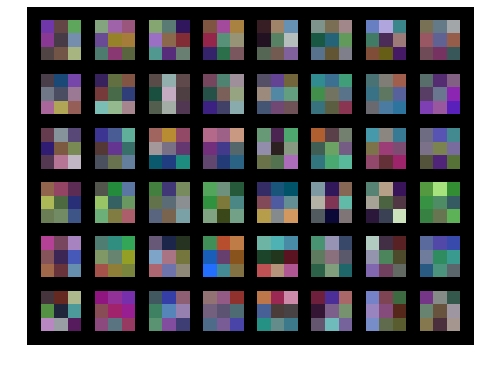

In [ ]:
filter = model.conv1.weight.data.clone()
visualizeTensor(filter)
plt.axis('off')
plt.ioff()
plt.show

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, l1=256, c1=48, c2=96, d1=0.1):
    super().__init__()
    self.d1 = 0.1
    self.conv1 = nn.Conv2d(3, 48, 5) # New Kernel Size
    self.conv2 = nn.Conv2d(48, 48, 3)
    self.conv3 = nn.Conv2d(48, 96, 3)
    self.conv4 = nn.Conv2d(96, 96, 3, stride=2)
    self.flat = nn.Flatten()
    self.batch_norm = nn.BatchNorm1d(96 * 121)
    self.fc1 = nn.Linear(96 * 121, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5)
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConvNet().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Saving Model

In [ ]:
torch.save(model.state_dict(), "cifar_conv.pth")

In [ ]:
model = ConvNet()
model.load_state_dict(torch.load("cifar_conv.pth"))

### Visualizing 5x5 filters

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.335602  [    0/50000]
loss: 1.641717  [12000/50000]
loss: 1.307958  [24000/50000]
loss: 1.523668  [36000/50000]
loss: 1.512978  [48000/50000]
Test Error: 
 Accuracy: 41.3%, Avg loss: 1.962583 

Epoch 2
-------------------------------
loss: 2.165060  [    0/50000]
loss: 1.179613  [12000/50000]
loss: 1.537408  [24000/50000]
loss: 1.522488  [36000/50000]
loss: 1.651891  [48000/50000]
Test Error: 
 Accuracy: 41.9%, Avg loss: 1.615539 

Epoch 3
-------------------------------
loss: 1.649027  [    0/50000]
loss: 1.054994  [12000/50000]
loss: 1.406232  [24000/50000]
loss: 1.497842  [36000/50000]
loss: 1.244770  [48000/50000]
Test Error: 
 Accuracy: 47.5%, Avg loss: 1.470345 

Epoch 4
-------------------------------
loss: 1.744670  [    0/50000]
loss: 1.324304  [12000/50000]
loss: 1.355288  [24000/50000]
loss: 1.457836  [36000/50000]
loss: 1.274979  [48000/50000]
Test Error: 
 Accuracy: 50.2%, Avg loss: 10.053359 

Epoch 5
-----------------------

<function matplotlib.pyplot.show(*args, **kw)>

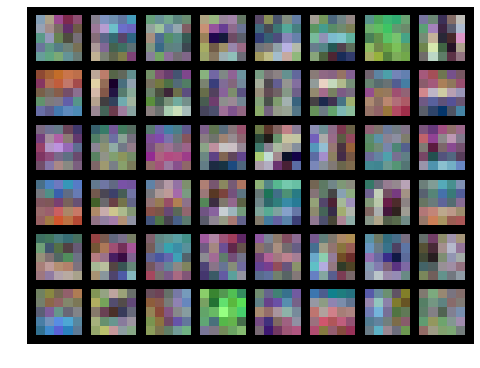

In [ ]:
filter = model.conv1.weight.data.clone()
visualizeTensor(filter)
plt.axis('off')
plt.ioff()
plt.show

# Hyperparameter Optimization

### Make the model architecture configurable

In [ ]:
class ConfigNet(nn.Module):
  def __init__(self, l1=256, c1=48, c2=96, d1=0.1):
    super().__init__()
    self.d1 = d1
    self.conv1 = nn.Conv2d(3, c1, 3)
    self.conv2 = nn.Conv2d(c1, c1, 3)
    self.conv3 = nn.Conv2d(c1, c2, 3)
    self.conv4 = nn.Conv2d(c2, c2, 3, stride=2)
    self.flat = nn.Flatten()
    self.batch_norm = nn.BatchNorm1d(c2 * 144)
    self.fc1 = nn.Linear(c2 * 144, l1)
    self.fc2 = nn.Linear(l1, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5)
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConfigNet().to(device)

### Image Augmentation

In [ ]:
# Augment Images for the train set
augmented = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Standard transformation for validation set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = CIFAR10(root="cifar",
                        train = True,
                        download = True,
                        transform=augmented)

test_data = CIFAR10(root = "cifar",
                    train = False,
                    download = True,
                    transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


### Define the Search Space for optimization

In [ ]:
search_space = {
    #'lr': [0.008, 0.005],
    # 'batch_size': [256, 512],
    # 'd1': [0.1, 0.2]
    'c1': [48, 96],
    'c2': [96, 192],
    'l1': [256, 512],
}

In [ ]:
best_results = {
    # 'lr': None,
    # 'bsz': None,
    # 'd1': None,
    'c1': None,
    'c2': None,
    'l1': None,
    'loss': None,
    'acc': 0
}

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, verbose=False, path="cifar-tune.pth"):
      self.tolerance = tolerance
      self.counter = 0
      self.early_stop = False
      self.lowest_loss = None
      self.verbose = verbose
      self.path = path

    def step(self, val_loss):
      if (self.lowest_loss == None):
        self.lowest_loss = val_loss
        torch.save(model.state_dict(), self.path)
      elif (val_loss < self.lowest_loss):
        self.lowest_loss = val_loss
        self.counter = 0
        torch.save(model.state_dict(), self.path)
      else:
        if self.verbose:
          print("Early stop counter: {}".format(self.counter+1))
        self.counter +=1
        if self.counter >= self.tolerance:
          self.early_stop = True
          if self.verbose:
            print('Early stopping executed.')

In [ ]:
class HyperSearch():
    def __init__(self, config, verbose=True):
      self.config = config
      self.verbose = verbose
      self.report_list = []
      self.best_results = { 'c1': None,
                            'c2': None,
                            'l1': None,
                            'loss': None,
                            'acc': 0
                            # 'd1': None,
                            # 'lr': None,
                            # 'bsz': None,
                          }

    # Optimization Method
    def optimize(self):
        for l1 in self.config['l1']:
            for c1 in self.config['c1']:
                for c2 in self.config['c2']:
                    early_stopping = EarlyStopping(tolerance=3, verbose=False, path="{}-{}-{}.pth".format(c1, c2, l1))

                    if self.verbose == True:
                        print('Conv1: {} | Conv2: {} | Lin1: {}'.format(str(c1), str(c2), str(l1)))
                    model = ConfigNet(l1=l1, c1=c1, c2=c2).to(device)

                    loss_fn = nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

                    train_dataloader = DataLoader(training_data, batch_size=batch_sz, shuffle=True, num_workers=0)
                    test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

                    epochs = 10
                    for t in range(epochs):
                        if self.verbose == True:
                            print(f"Epoch {t+1}\n-------------------------------")
                        train_loss = train(train_dataloader, model, loss_fn, optimizer, verbose=self.verbose)
                        test_loss, test_acc = test(test_dataloader, model, loss_fn, verbose=self.verbose)

                        # Early Stopping
                        early_stopping.step(test_loss)
                        if early_stopping.early_stop:
                          break
                    print("Done!")
                    self.append_to_report(test_acc, test_loss, c1, c2, l1)

                    if self.best_results['loss'] == None or test_loss < self.best_results['loss']:
                        if self.verbose == True:
                            print("UPDATE: Best loss changed from {} to {}".format(self.best_results['loss'], test_loss))
                        self.best_results.update({
                            'c1': c1,
                            'c2': c2,
                            'loss': test_loss,
                            'l1': l1,
                            'acc': test_acc
                        })
        self.report()

    def report(self):
        print("""
|-----------------------------------------------------------------------------------------------------|
|                                                                                                     |
|                              Report for hyperparameter optimization                                 |
|                                                                                                     |
|-----------------------------------------------------------------------------------------------------|
|    RUN     |              PERFORMANCE             |                   CONFIGURATION                 |
|------------|--------------------------------------|-------------------------------------------------|""")
        for idx, item in enumerate(self.report_list):
            
            print("|   Run {:02d}   |  Accuracy: {:.2f}%   |   Loss: {:.2f}   |  Conv-1: {}  |  Conv-2: {:3}  |  Linear-1: {:>4}  |".format(idx,
                                                                                                                                       item[0]*100,
                                                                                                                                       item[1],
                                                                                                                                       item[2],
                                                                                                                                       item[3],
                                                                                                                                       item[4]))
            print("|------------|---------------------|----------------|--------------|---------------|------------------|")
        print("\nBest Results | Accuracy: {:.2f}%  |  Loss: {:.2f}  |  Conv-1: {}   |  Conv-2: {}  |  Linear-1: {:>4}  |".format(self.best_results['acc']*100,
                                                                                                                                              self.best_results['loss'],
                                                                                                                                              self.best_results['c1'],
                                                                                                                                              self.best_results['c2'],
                                                                                                                                              self.best_results['l1']))

    def append_to_report(self, acc, loss, c1, c2, l1):
        list_set = (acc, loss, c1, c2, l1)
        self.report_list.append(list_set)



In [ ]:
%%time

lrate=0.001
batch_sz=512

hyper_search = HyperSearch(search_space, verbose=True)

hyper_search.optimize()

Conv1: 48 | Conv2: 96 | Lin1: 256
Epoch 1
-------------------------------
loss: 2.334770  [    0/50000]
loss: 1.573388  [25600/50000]
Test Error: 
 Accuracy: 49.4%, Avg loss: 1.414770 

Epoch 2
-------------------------------
loss: 1.441251  [    0/50000]
loss: 1.192763  [25600/50000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.286341 

Epoch 3
-------------------------------
loss: 1.296272  [    0/50000]
loss: 1.253879  [25600/50000]
Test Error: 
 Accuracy: 60.8%, Avg loss: 1.094024 

Epoch 4
-------------------------------
loss: 1.214479  [    0/50000]
loss: 1.085186  [25600/50000]
Test Error: 
 Accuracy: 61.3%, Avg loss: 1.092242 

Epoch 5
-------------------------------
loss: 1.029082  [    0/50000]
loss: 1.039972  [25600/50000]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.988008 

Epoch 6
-------------------------------
loss: 1.082698  [    0/50000]
loss: 1.038053  [25600/50000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.987689 

Epoch 7
-------------------------------
loss: 0.997165

# Fine Tuning Best Model

In [ ]:
model = ConfigNet()
model.load_state_dict(torch.load("48-96-256.pth"))

<All keys matched successfully>

In [ ]:
class ConfigNet(nn.Module):
  def __init__(self, l1=256, c1=48, c2=96, d1=0.1):
    super().__init__()
    self.d1 = d1
    self.conv1 = nn.Conv2d(3, c1, 3)
    self.conv2 = nn.Conv2d(c1, c1, 3)
    self.conv3 = nn.Conv2d(c1, c2, 3)
    self.conv4 = nn.Conv2d(c2, c2, 3, stride=2)
    self.flat = nn.Flatten()
    self.batch_norm = nn.BatchNorm1d(c2 * 144)
    self.fc1 = nn.Linear(c2 * 144, l1)
    self.fc2 = nn.Linear(l1, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5)
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConfigNet().to(device)

In [ ]:
model = ConfigNet(l1=256, c1=48, c2=96, d1=0.1).to(device)
batch_sz = 512
lrate = 0.0008

In [ ]:
%%time
early_stopping = EarlyStopping(tolerance=6, verbose=True, path="cifar-optimized-test.pth")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

train_dataloader = DataLoader(training_data, batch_size=batch_sz, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)

    # Early Stopping
    early_stopping.step(test_loss)
    if early_stopping.early_stop:
      break
print("Done!")


Epoch 1
-------------------------------
loss: 2.314620  [    0/50000]
loss: 1.527308  [25600/50000]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.443652 

Epoch 2
-------------------------------
loss: 1.465110  [    0/50000]
loss: 1.278300  [25600/50000]
Test Error: 
 Accuracy: 57.3%, Avg loss: 1.200827 

Epoch 3
-------------------------------
loss: 1.232478  [    0/50000]
loss: 1.220792  [25600/50000]
Test Error: 
 Accuracy: 60.5%, Avg loss: 1.114708 

Epoch 4
-------------------------------
loss: 1.120637  [    0/50000]
loss: 0.964464  [25600/50000]
Test Error: 
 Accuracy: 63.8%, Avg loss: 1.037358 

Epoch 5
-------------------------------
loss: 1.020233  [    0/50000]
loss: 1.068292  [25600/50000]
Test Error: 
 Accuracy: 64.4%, Avg loss: 1.021972 

Epoch 6
-------------------------------
loss: 0.935966  [    0/50000]
loss: 0.926343  [25600/50000]
Test Error: 
 Accuracy: 69.2%, Avg loss: 0.891543 

Epoch 7
-------------------------------
loss: 0.912772  [    0/50000]
loss: 0.902210  [2

# Model Evaluation

In [ ]:
model = ConfigNet(l1=256, c1=48, c2=96, d1=0.1).to(device)
model.load_state_dict(torch.load("cifar-optimized-test.pth"))

<All keys matched successfully>

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_sz = 512

test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=False, num_workers=0)
classes = test_data.classes

In [ ]:
test_loss, test_acc = test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.677788 



In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0  for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)

    for label,prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

Accuracy for class airplane: 85.3%
Accuracy for class automobile: 82.8%
Accuracy for class bird : 67.7%
Accuracy for class cat  : 54.2%
Accuracy for class deer : 65.4%
Accuracy for class dog  : 57.1%
Accuracy for class frog : 89.5%
Accuracy for class horse: 74.1%
Accuracy for class ship : 83.3%
Accuracy for class truck: 87.5%


### Confusion Matrix

In [ ]:
num_classes = 10

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


print(confusion_matrix)

tensor([[786.,  23.,  52.,  17.,  17.,   1.,   4.,  10.,  54.,  36.],
        [  9., 911.,   3.,   3.,   4.,   2.,   3.,   0.,  26.,  39.],
        [ 48.,   1., 730.,  42.,  64.,  32.,  50.,  18.,  11.,   4.],
        [ 14.,   8., 100., 639.,  44., 113.,  41.,  14.,  14.,  13.],
        [ 18.,   2.,  83.,  51., 721.,  31.,  43.,  43.,   7.,   1.],
        [  6.,   2.,  73., 176.,  29., 656.,  17.,  30.,   4.,   7.],
        [  5.,   5.,  54.,  44.,  21.,   8., 854.,   3.,   5.,   1.],
        [ 13.,   6.,  42.,  44.,  52.,  54.,   7., 765.,   6.,  11.],
        [ 48.,  29.,  15.,  13.,   4.,   4.,   6.,   2., 853.,  26.],
        [ 17.,  60.,   6.,  11.,   0.,   3.,   5.,   3.,  25., 870.]])


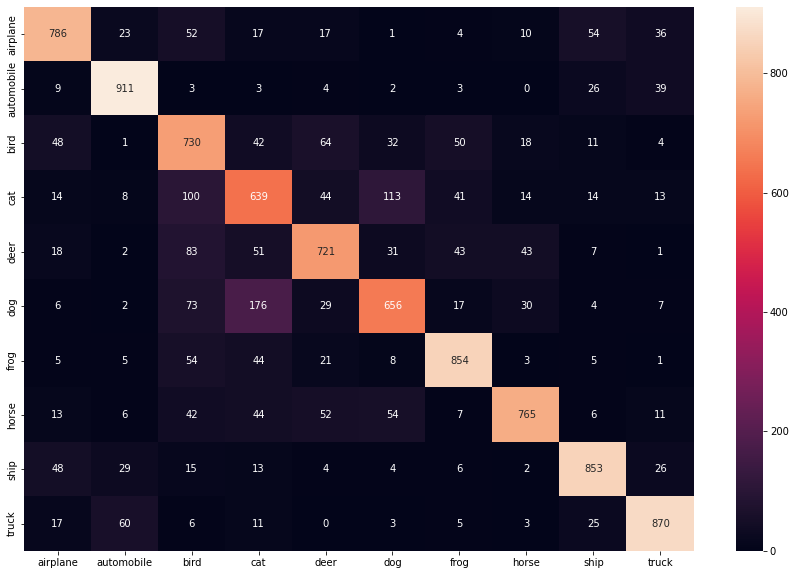

In [ ]:
plt.figure(figsize=(15,10))
cf_dataframe = pd.DataFrame(np.array(confusion_matrix, dtype='int'), index=test_data.classes, columns=test_data.classes)
heatmap = sns.heatmap(cf_dataframe, annot=True, fmt='g')

### Recall per class Confusion Matrix

In [ ]:
cf = np.array(confusion_matrix)
norm_cf = cf / cf.astype(float).sum(axis=1)

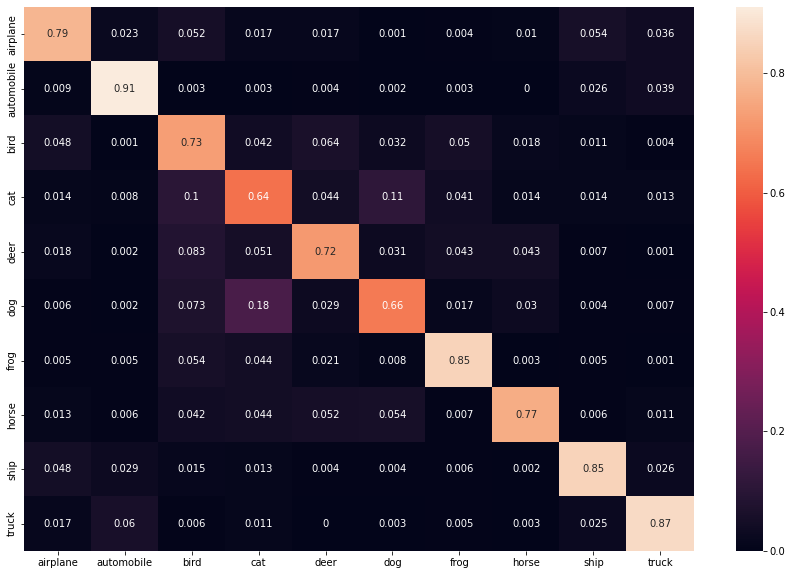

In [ ]:
plt.figure(figsize=(15,10))
cf_dataframe = pd.DataFrame(np.array(norm_cf, dtype='float64'), index=test_data.classes, columns=test_data.classes).astype(float)
heatmap = sns.heatmap(cf_dataframe, annot=True)

### Precision per class Confusion Matrix

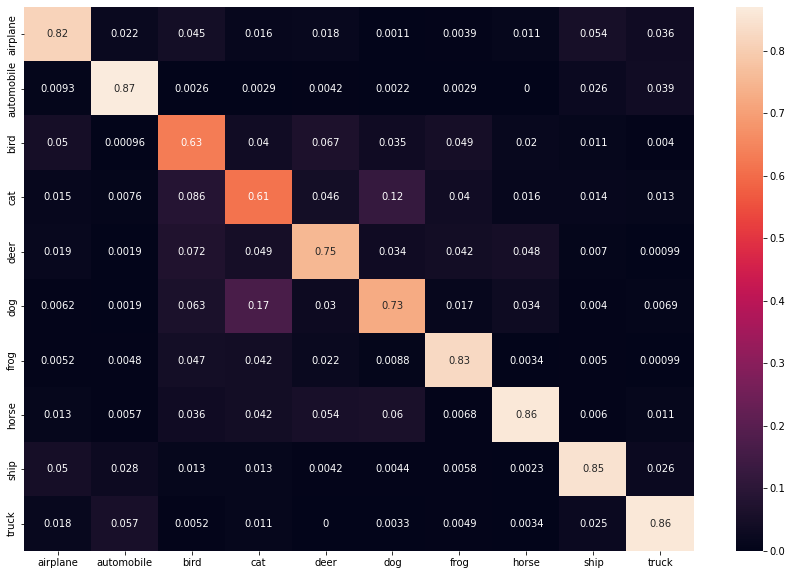

In [ ]:
cf = np.array(confusion_matrix)
norm_cf = cf / cf.astype(float).sum(axis=0)

plt.figure(figsize=(15,10))
cf_dataframe = pd.DataFrame(np.array(norm_cf, dtype='float64'), index=test_data.classes, columns=test_data.classes).astype(float)
heatmap = sns.heatmap(cf_dataframe, annot=True)

### Sample Model Predictions

In [ ]:
def imshow(img):
    img = img / 2 + .05 # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [ ]:
test_data = CIFAR10(root = "cifar",
                    train = False,
                    transform = transforms.ToTensor())
classes = test_data.classes

In [ ]:
def sample_predictions(n = 4):
    test_dataloader = DataLoader(test_data, batch_size=n, shuffle=True, num_workers=0)
    dataiter = iter(test_dataloader)
    images, labels = dataiter.next()

    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

    imshow(make_grid(images))
    print('[Ground Truth | Predicted]:\n', ' '.join(f'[{classes[labels[j]]:5s} | {classes[predicted[j]]:5s}]\n' for j in range(n)))

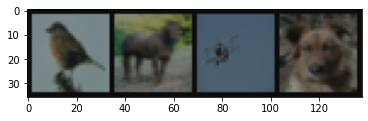

[Ground Truth | Predicted]:
 [bird  | bird ]
 [horse | horse]
 [airplane | bird ]
 [dog   | dog  ]



In [ ]:
sample_predictions(4)

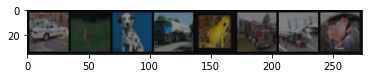

[Ground Truth | Predicted]:
 [automobile | airplane]
 [deer  | airplane]
 [dog   | dog  ]
 [truck | airplane]
 [frog  | frog ]
 [truck | cat  ]
 [airplane | deer ]
 [frog  | frog ]



In [ ]:
sample_predictions(8)

# See Intermediate Outputs

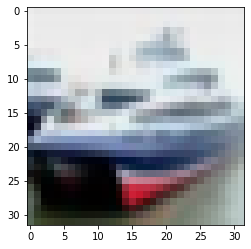

torch.Size([1, 3, 32, 32])


In [ ]:
T = transforms.ToPILImage()
img = T(test_data[1][0])
plt.imshow(img)
plt.show()
 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

img=np.array(img)
img=transform(img)
img=img.unsqueeze(0)
print(img.size())

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child.to('cpu'))
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

4


In [ ]:
results = [conv_layers[0](img).to('cpu')]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


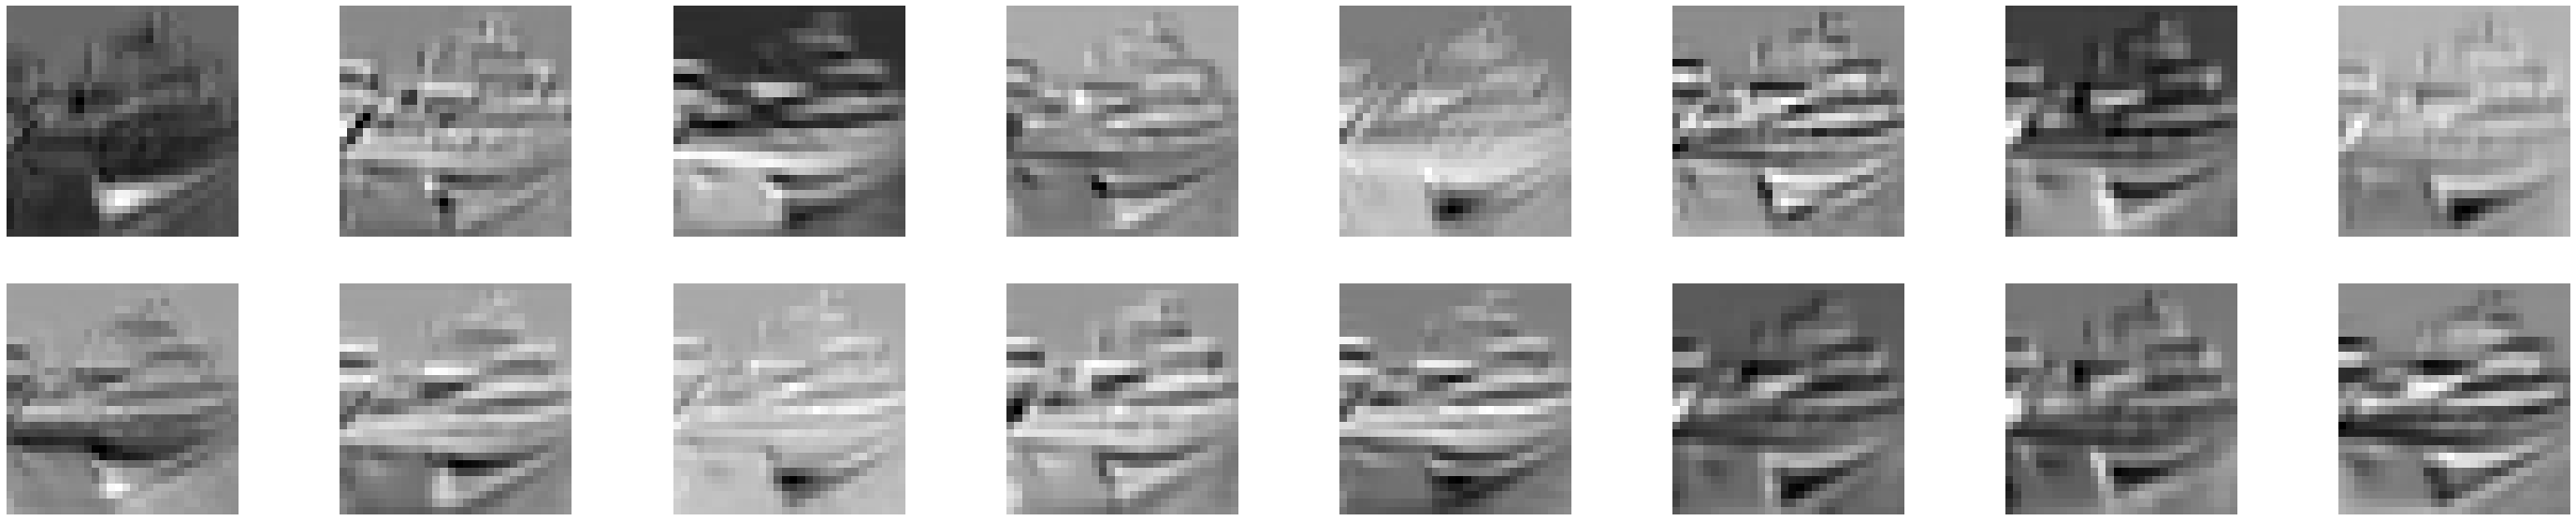

Layer  2


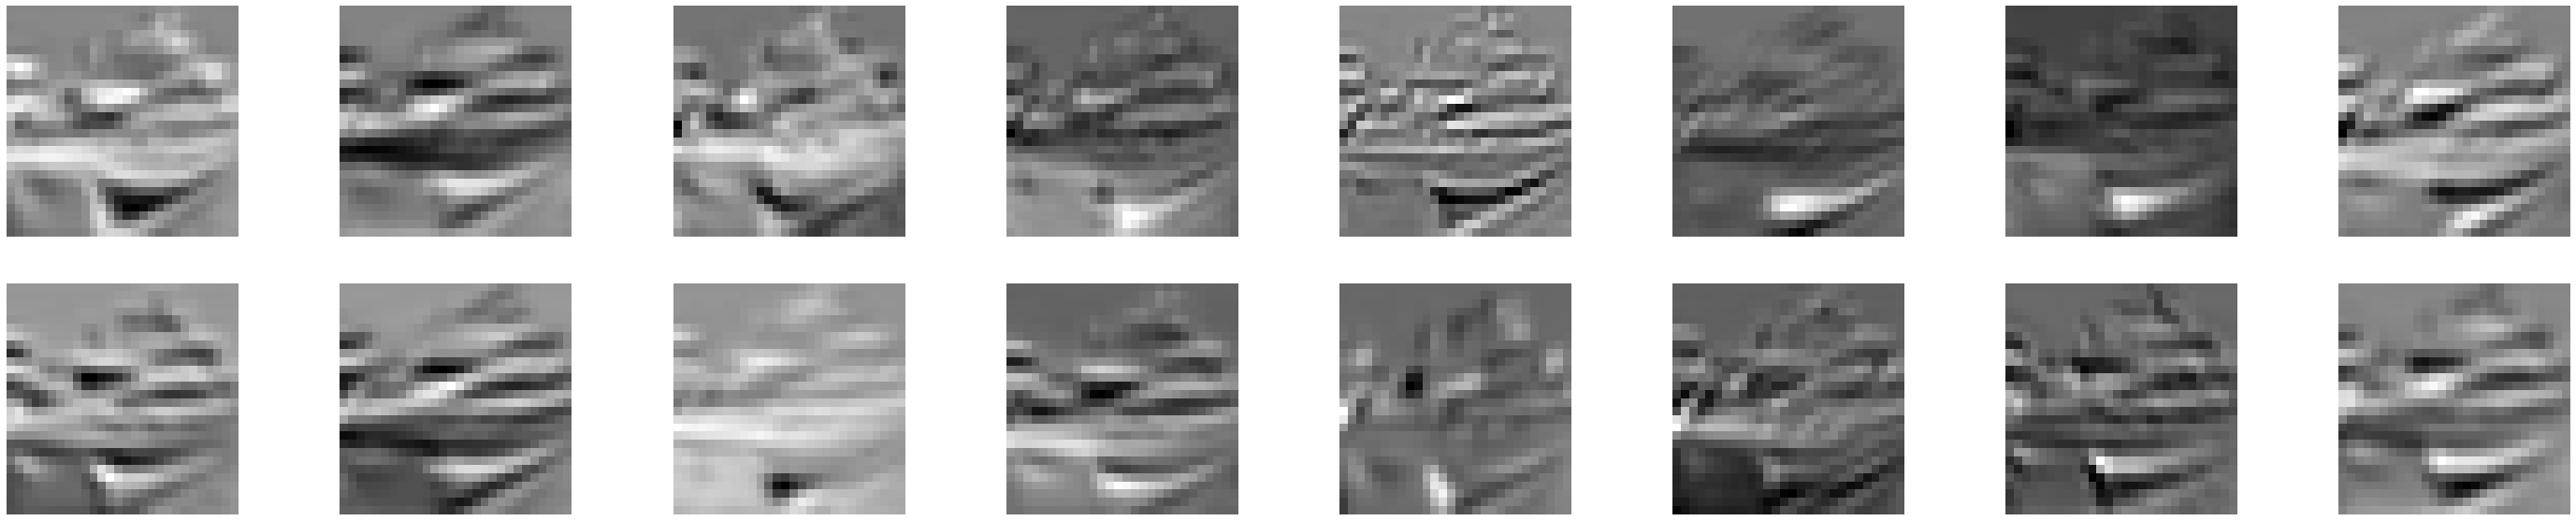

Layer  3


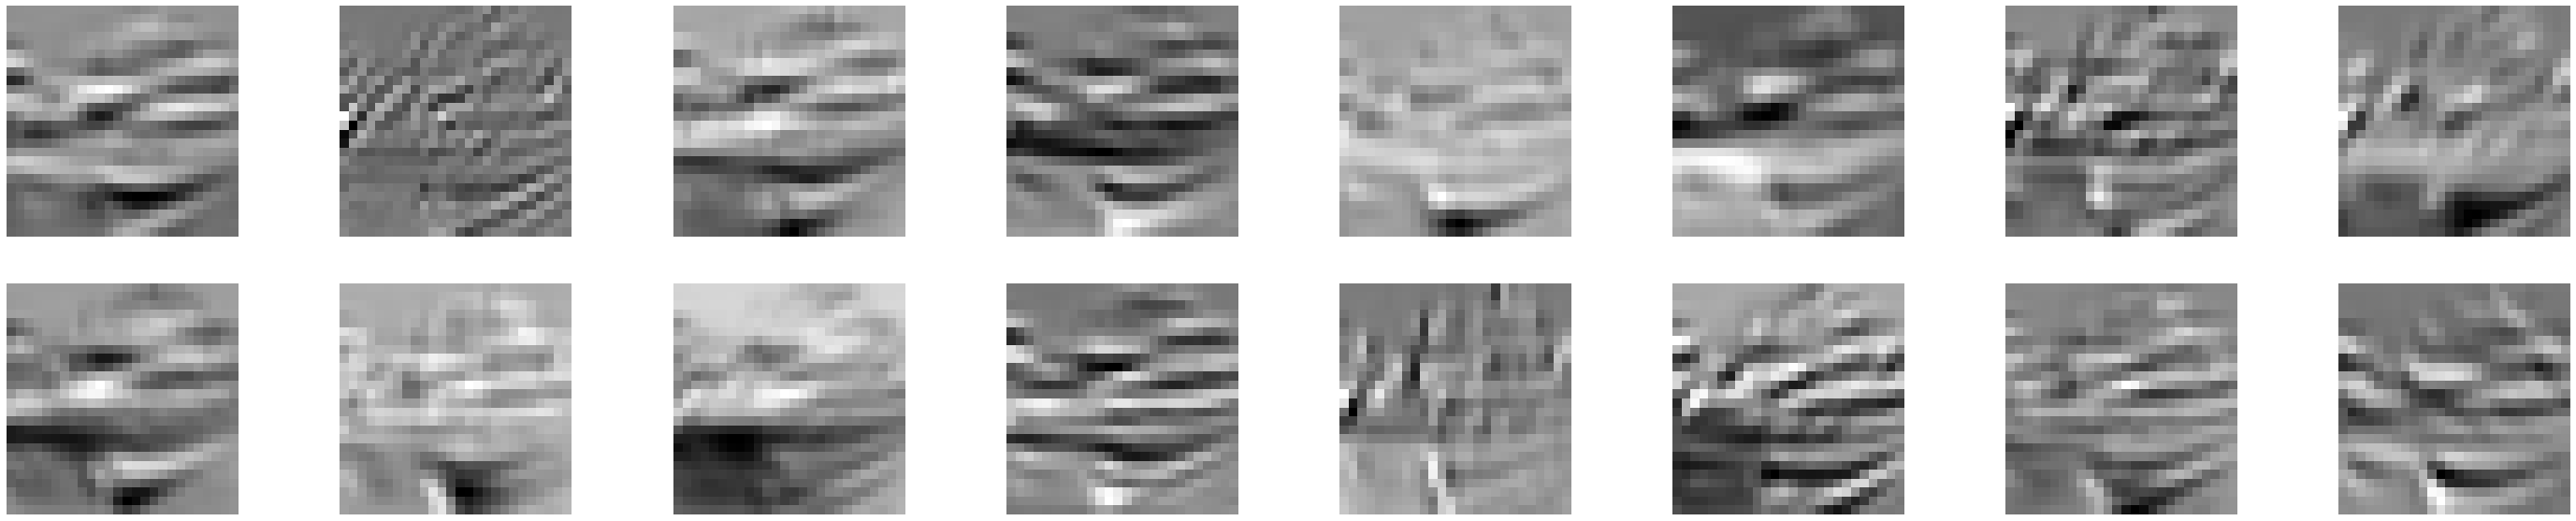

Layer  4


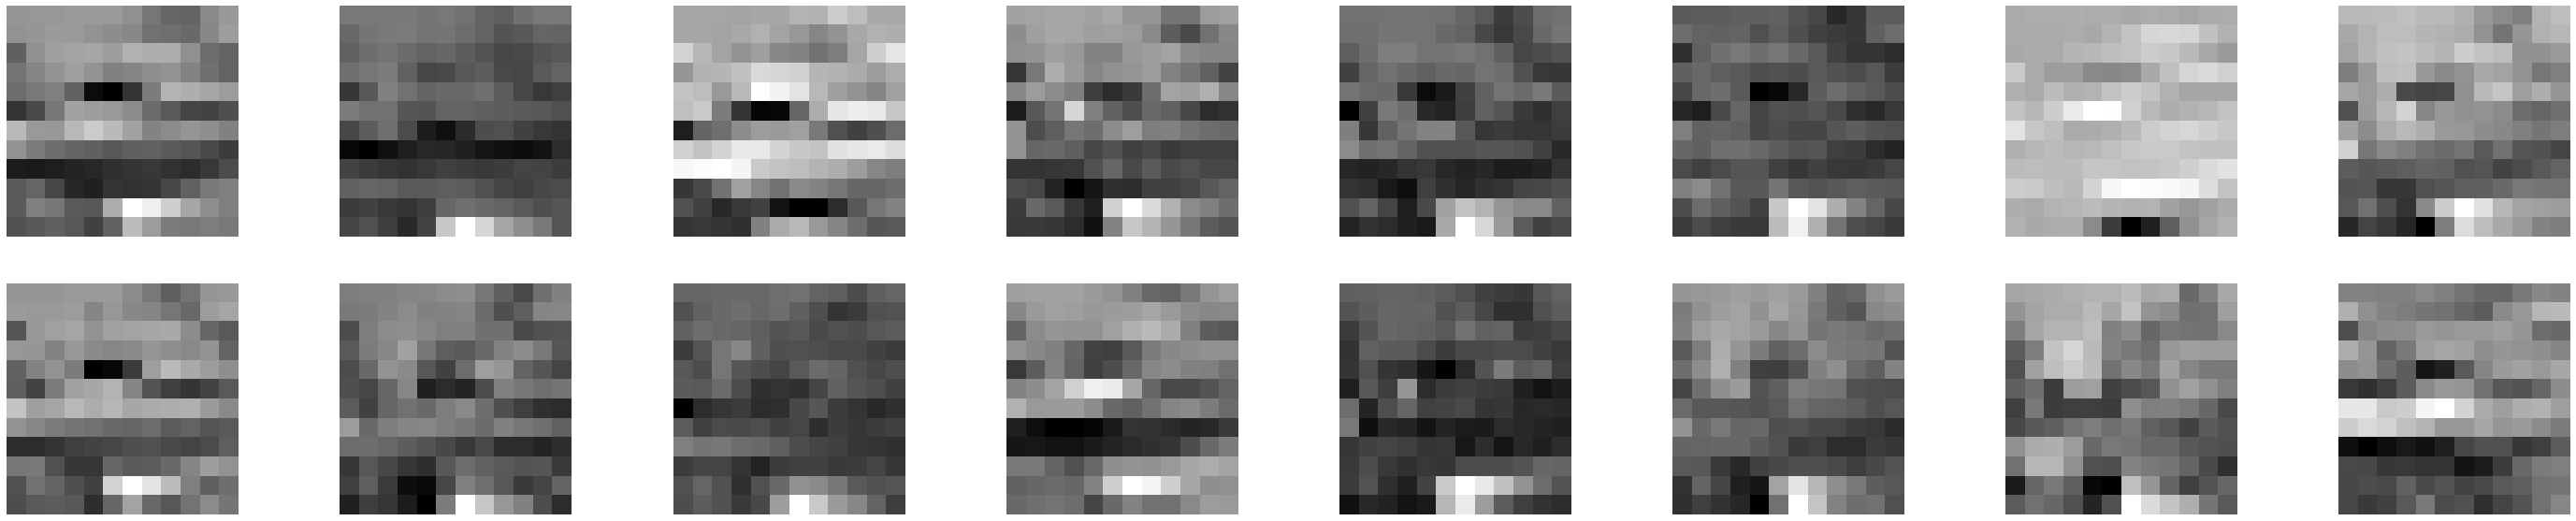

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
mdl = model.to('cpu')
mdl.eval()
output = mdl(img)
_, pred = torch.max(output, 1)
print(classes[pred])

ship
